# Redes Neuronales Profundas

Este Notebook contiene paso a paso las instrucciones necesarias para crear una red neuronal profunda multicapa que ayuda a clasificar si un personaje animado femenino será agradable para otras personas. El adjetivo que describe esta característica de un personaje animado es "waifu" (españolización para la palabra en inglés "wife", que significa "esposa").
Este proyecto fue desarrollado para la clase de "Aprendizaje Profundo", impartida por el Dr. Leonardo Garrido.

15 de Mayo 2019

**Elaborado por:**
- A01550742 Guillermo A. Mendoza Soni. 
- A01280151 Rolando Ruiz Guerrero

## 1 - Paquetes

La siguiente lista de paquetes fue utilizada para crear la red neuronal profunda:
- [numpy](www.numpy.org) un paquete para ciencia computacional de Python.
- [matplotlib](http://matplotlib.org) una librería para hacer gráficas.
- [h5py](http://www.h5py.org) un paquete para interactuar con el set de datos que se encuentra almacenado en archivo de tipo H5
- [PIL](http://www.pythonware.com/products/pil/) y [scipy](https://www.scipy.org/) usados para probar el modelo con imagenes.
- dnn_app_utils un archivo que contiene funciones que ayudan a precargar datos, también contiene funciones que son de utilidad para construir la red neuronal profunda.
- np.random.seed(1) se fija la semilla de la función que genera números aleatorios, de esta manera se pueden recrear los resultados de manera precisa.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(50)

## 2 - Data Set

You will use the same "Cat vs non-Cat" dataset as in "Logistic Regression as a Neural Network" (Assignment 2). The model you had built had 70% test accuracy on classifying cats vs non-cats images. Hopefully, your new model will perform a better!

El data set, como se mencionó en el título, contiene imágenes de protagonistas de dibujos animados. Este data set se encuentra dividido en archivos H5:
    - test_waifu.h5
    - train_waifu.h5
    - dev_waifu.h5

Cada uno de estos archivos contiene dos sets de datos:
    - Columna X: el set de imagenes
    - Columna Y: el set de etiquetas con '1' y '0' donde 1=es waifu, y 0=no es waifu.

El código de abajo utiliza la función "load_data" que se encarga de desencapsular estos sets de datos en variables que se manejaran para el entrenamiento de la red neuronal profunda.

In [11]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

El siguiente código desplegará una imagen del set de datos que se utiliará en el entrenamiento. El set de datos contiene imagenes a color en formato RGB, con 256 pixeles de alto por 256 pixeles de ancho.

y = 1. She's not waifu material (yet)


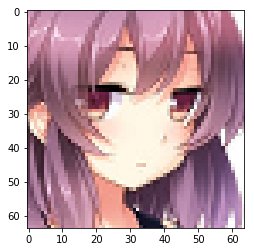

In [12]:
# Example of a picture
index = 389
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". She's " + classes[train_y[0,index]])

In [13]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 400
Number of testing examples: 200
Each image is of size: (64, 64, 3)
train_x_orig shape: (400, 64, 64, 3)
train_y shape: (1, 400)
test_x_orig shape: (200, 64, 64, 3)
test_y shape: (1, 200)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [14]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 400)
test_x's shape: (12288, 200)


$64 \times 64 \times 3$ es igual a $12,288$, este último número es el tamaño del vector que representa una imagen

## 3 - Construyendo la Red Neuronal Profunda

Como se mencionó en el apartado **1-Paquetes**, del archivo _dnn_app_utils.py_ se importan algunas funciones que ayudan a hacer las operaciones necesarias para construir la red neuronal profunda. Estas funciones ya fueron programadas en tareas del curso de "Aprendizaje Automático" y serán reutilizadas en esta sección. A continuación se muestra una lista de las funciones que se utilizarán:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

### 3.1 - Red Neuronal Profuna sin parámetros ajustados

En la tarea 9 del curso de "Aprendizaje Profundo", se realizó una red profunda que clasificaba si una imagen contenía un gato o no. Se utilizará la misma arquitectura e hiper-parámetros de esa red neuronal, para tomarla como un punto de partida antes de hacer los ajustes necesarios a la red para optimizar su clasificación. La misma red neuronal de la tarea 9 también servirá como referencia para saber si el ajuste hecho a la red neuronal, ha mejorado su certeza de clasificación a lo largo de los 3 sets de datos.

#### 3.1.1 - Arquitectura

La arquitectura de la siguiente red neuronal es la siguiente:

_**Capas**_
- 4 capas
    - 1 capa de entrada 
    - 3 capas ocultas        
    
_**Neuronas**_
- Capa 1: 12,288 neuronas
- Capa 2: 20 neuronas
- Capa 3: 7 neuronas
- Capa 4: 5 neuronas


#### 3.1.2 - Hyper-parámetros

Estos son los hyper parámetros utilizados:
- Ritmo de aprendizaje: 0.0075
- Iteraciones: 2500

#### 3.1.3 - Código

Es necesario ejecutar los siguientes bloques de código en orden. Algunas secciones contienen mensajes debajo con el título _"Salida esperada"_, que indica lo que debe de desplegar el código una vez que haya sido ejecutado.

In [15]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [16]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    #np.random.seed(100)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

El código que se muestra abajo, entrena la red neuronal profunda con la arquitectura mencionada en la seccción **3.1.1** y con los hiper-parámetros indicados en la sección **3.1.2**. Para el entrenamiento utilizará el set de datos de las variables ```python train_x``` y ```python train_y``` (que contienen los set de datos 'X' e 'Y' del archivo _test_waifus.h5_).

Al ejecutar la función, se desplegará el costo cada 100 iteraciones. Esta salida servirá para comprobar que el costo disminuye conforme se itera sobre la función. 

La función tomará de 5 a 10 minutos en terminar de ejecutarse, dependiendo del procesador de la computadora donde se esté ejecutando este _Jupyter Notebook_. Al terminar, aparecerá una gráfica donde se podra observar de mejor manera el costo contra las iteraciones hechas.

Cost after iteration 0: 0.701196
Cost after iteration 100: 0.675246
Cost after iteration 200: 0.619569
Cost after iteration 300: 0.581602
Cost after iteration 400: 0.559783
Cost after iteration 500: 0.570235
Cost after iteration 600: 0.696187
Cost after iteration 700: 0.558258
Cost after iteration 800: 0.555436
Cost after iteration 900: 0.571613
Cost after iteration 1000: 0.568041
Cost after iteration 1100: 0.559047
Cost after iteration 1200: 0.602988
Cost after iteration 1300: 0.684140
Cost after iteration 1400: 0.595580
Cost after iteration 1500: 0.521168
Cost after iteration 1600: 0.547239
Cost after iteration 1700: 0.436222
Cost after iteration 1800: 0.418119
Cost after iteration 1900: 0.458427
Cost after iteration 2000: 0.588272
Cost after iteration 2100: 0.401312
Cost after iteration 2200: 0.440684
Cost after iteration 2300: 0.354415
Cost after iteration 2400: 0.368894
Cost after iteration 2500: 0.647929
Cost after iteration 2600: 0.604817
Cost after iteration 2700: 0.738018
Cost

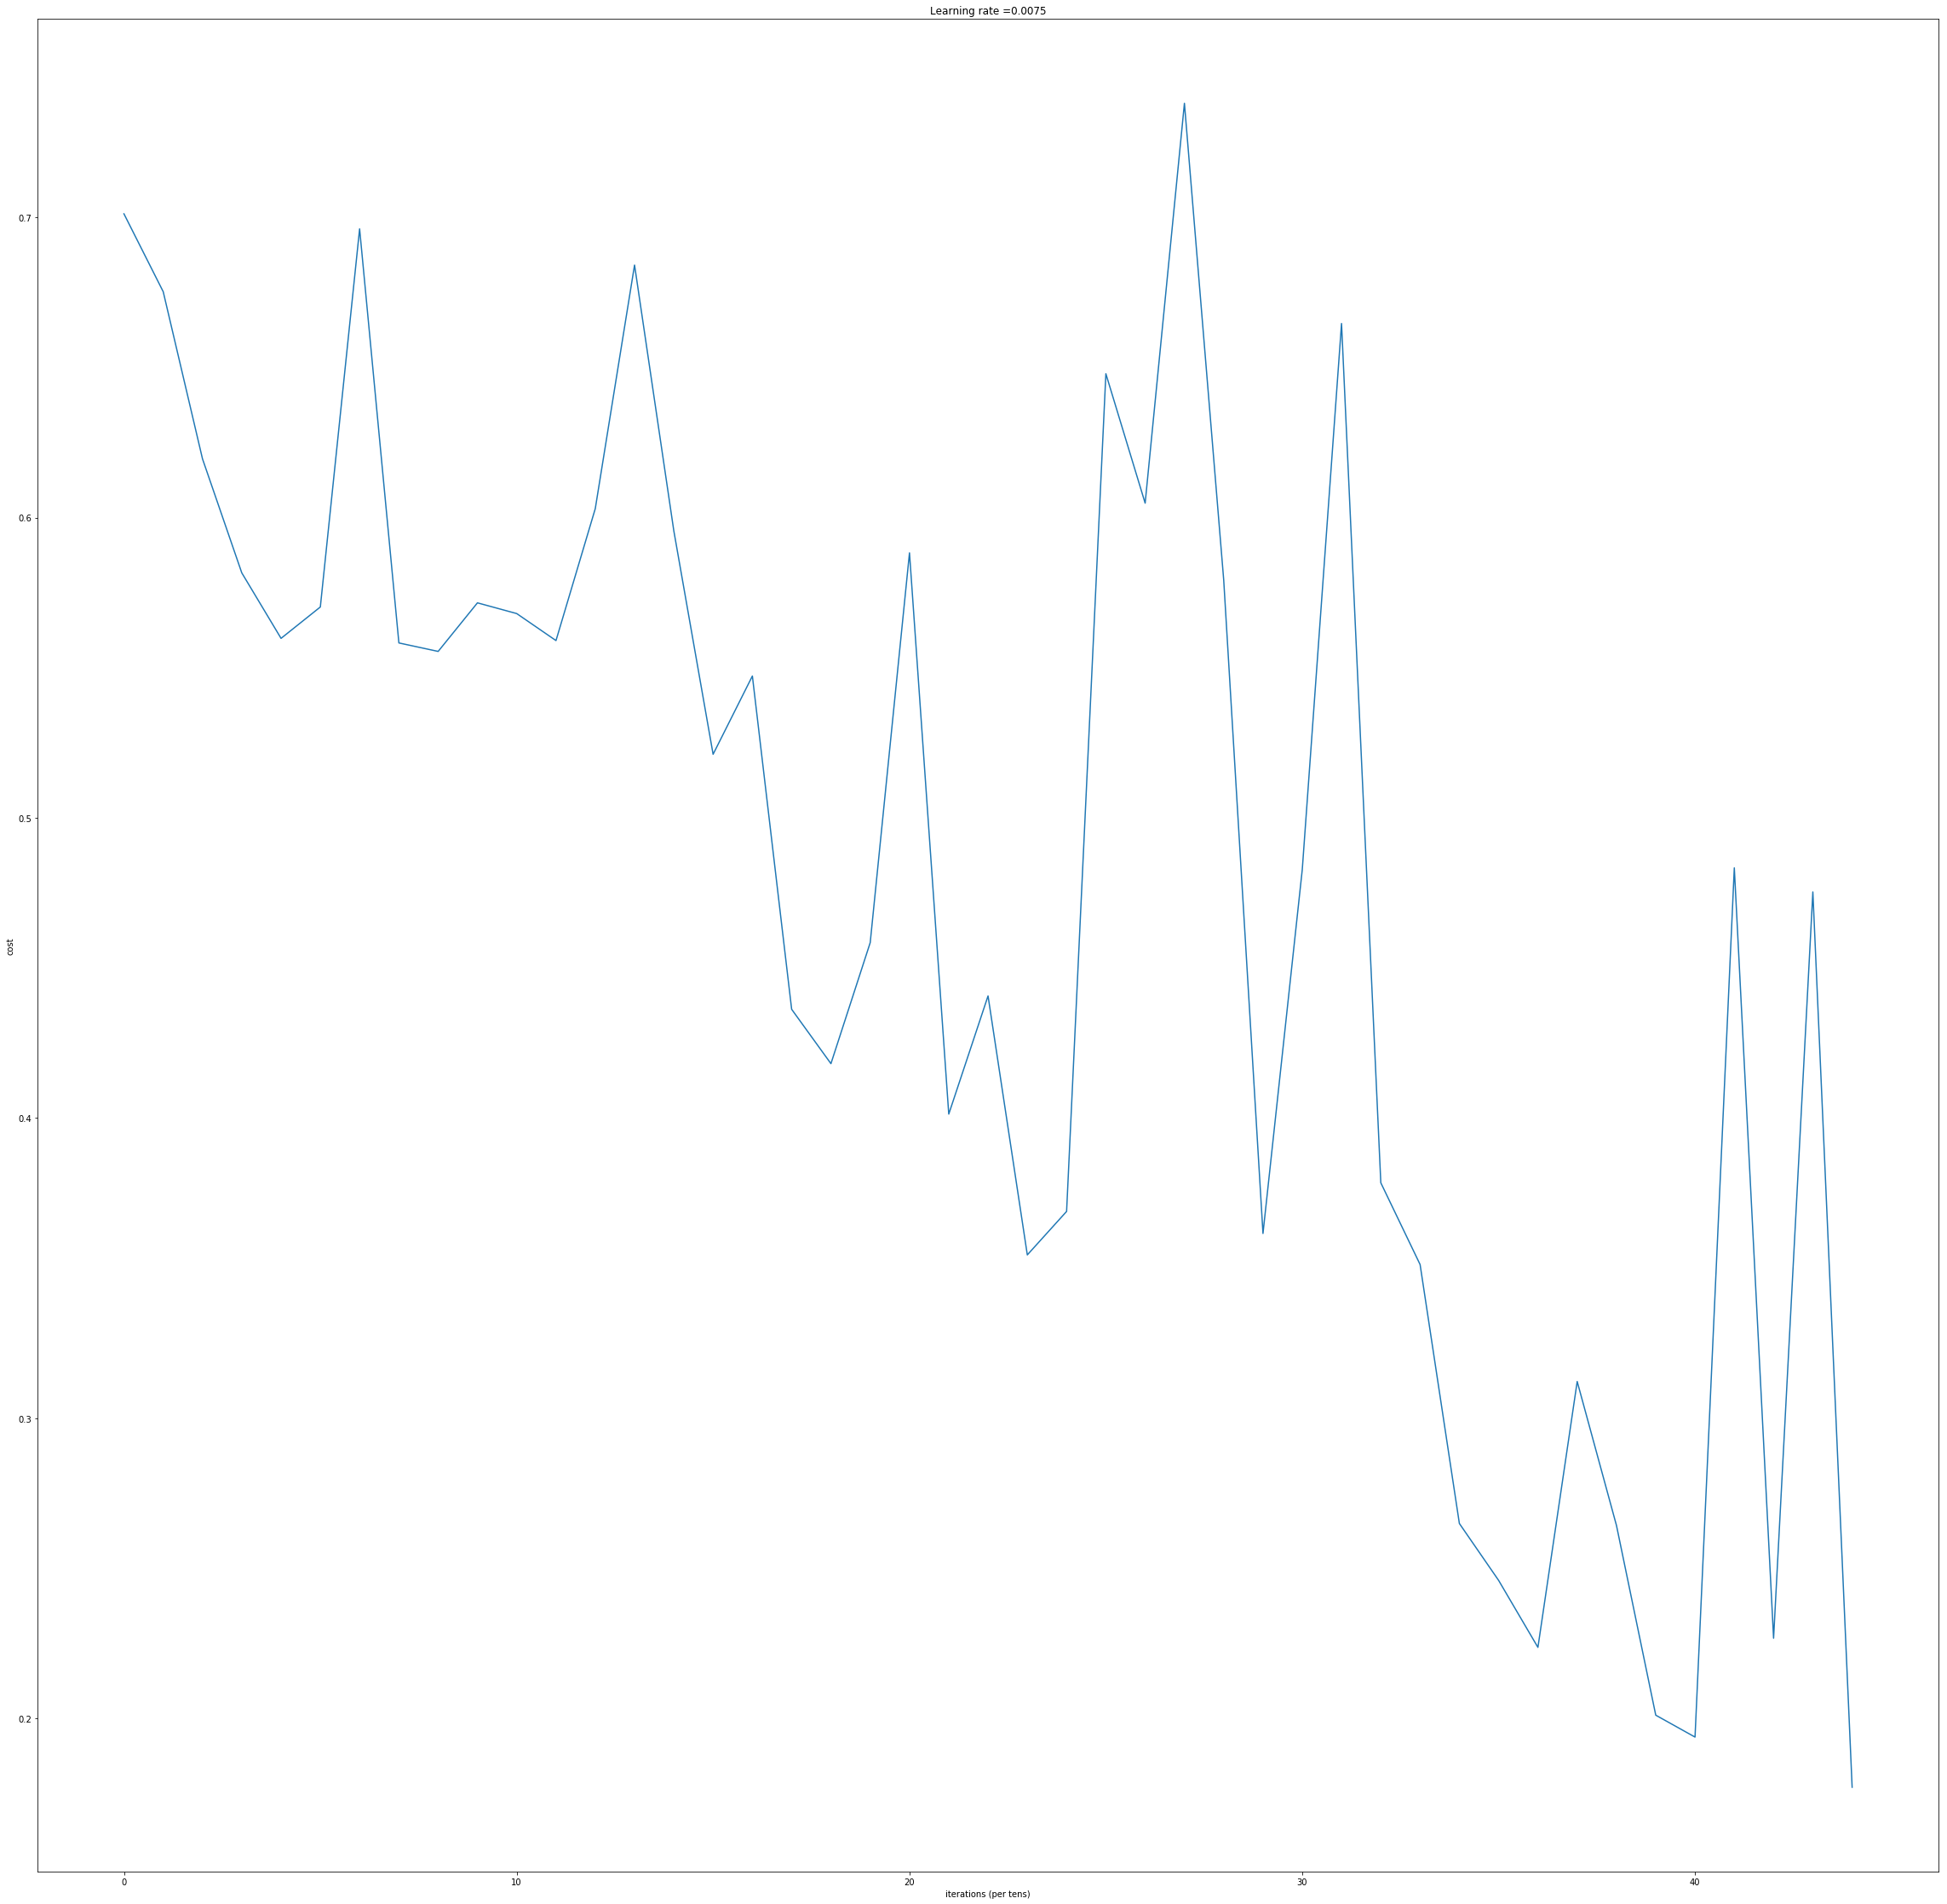

In [49]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 4500, print_cost = True)

**Salida esperada**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.687414 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.599836 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 200**</td>
        <td> 0.621004 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.112793 </td>
    </tr>
</table>

El siguiente código, indica la precisión de la red neuronal profunda entrenada con el set de datos de entrenamiento. La manera en que se está midiendo la precisión, es el porcentaje de instancias correctamente clasificadas.

In [18]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.6724999999999999


**Salida esperada**:
<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
    0.9949999999999999
    </td>
    </tr>
</table>

A continuación se hará el mismo proceso que en el paso anterior, pero ahora se verificará la precisión de la red neuronal profunda, contra un set de datos con los que no ha sido entrenada y, por lo tanto, imagenes que la red no ha "visto".

In [19]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.61


**Salida esperada**:

<table> 
    <tr>
        <td> **Test Accuracy** </td>
        <td> 0.505 </td>
    </tr>
</table>

Como se puede observar se obtuvieron los siguientes valores de precisón:
- **set de entrenamiento**: 99.49%
- **set de prueba**: 50.50%

El primer porcentaje indica que la red neuronal profunda logró clasificar muy bien los ejemplos con los que fue entrenada. Sin embargo cuando se observa el porcentaje de la precisión con un data set distinto, la precisión baja a la mitad. Esto es un indicador de **overfitting**, es decir, la red neuronal profunda está aprendiendo tal cual los ejemplos del entrenamiento sin realizar una buena generalización.

Ahora pasemos a la segunda red neuronal profunda.

### 3.2 - Red Neuronal Profuna con parámetros ajustados

Con los valores anteriormente obtenidos se procedió a buscar otros parámetros y arquitectura que mejorara la precisión de la red neuronal profunda. A continuación se muestran la arquitectura e hiper-parámetros encontrados.

#### 3.2.1 - Arquitectura

La arquitectura de la siguiente red neuronal es la siguiente:

_**Capas**_
- _N_ capas
    - 1 capa de entrada 
    - _N_ capas ocultas        
    
_**Neuronas**_
- Capa 1: 12,288 neuronas
- Capa 2: ## neuronas
- Capa 3: ## neuronas
- Capa 4: ## neuronas
- Capa N: ## neuronas


#### 3.2.2 - Hyper-parámetros

Estos son los hyper parámetros utilizados:
- Ritmo de aprendizaje: ####
- Iteraciones: ####

#### 3.2.3 - Código
Ejecúte los siguientes bloques de código en orden, esperando la salida de cada uno (solo para los bloques que debajo contienen el mensaje de "Salida esperada") antes de continuar con el siguiente.

In [31]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

Cost after iteration 0: 0.701196
Cost after iteration 100: 0.675246
Cost after iteration 200: 0.619569
Cost after iteration 300: 0.581602
Cost after iteration 400: 0.559783
Cost after iteration 500: 0.570235
Cost after iteration 600: 0.696187
Cost after iteration 700: 0.558258
Cost after iteration 800: 0.555436
Cost after iteration 900: 0.571613
Cost after iteration 1000: 0.568041
Cost after iteration 1100: 0.559047
Cost after iteration 1200: 0.602988
Cost after iteration 1300: 0.684140
Cost after iteration 1400: 0.595580


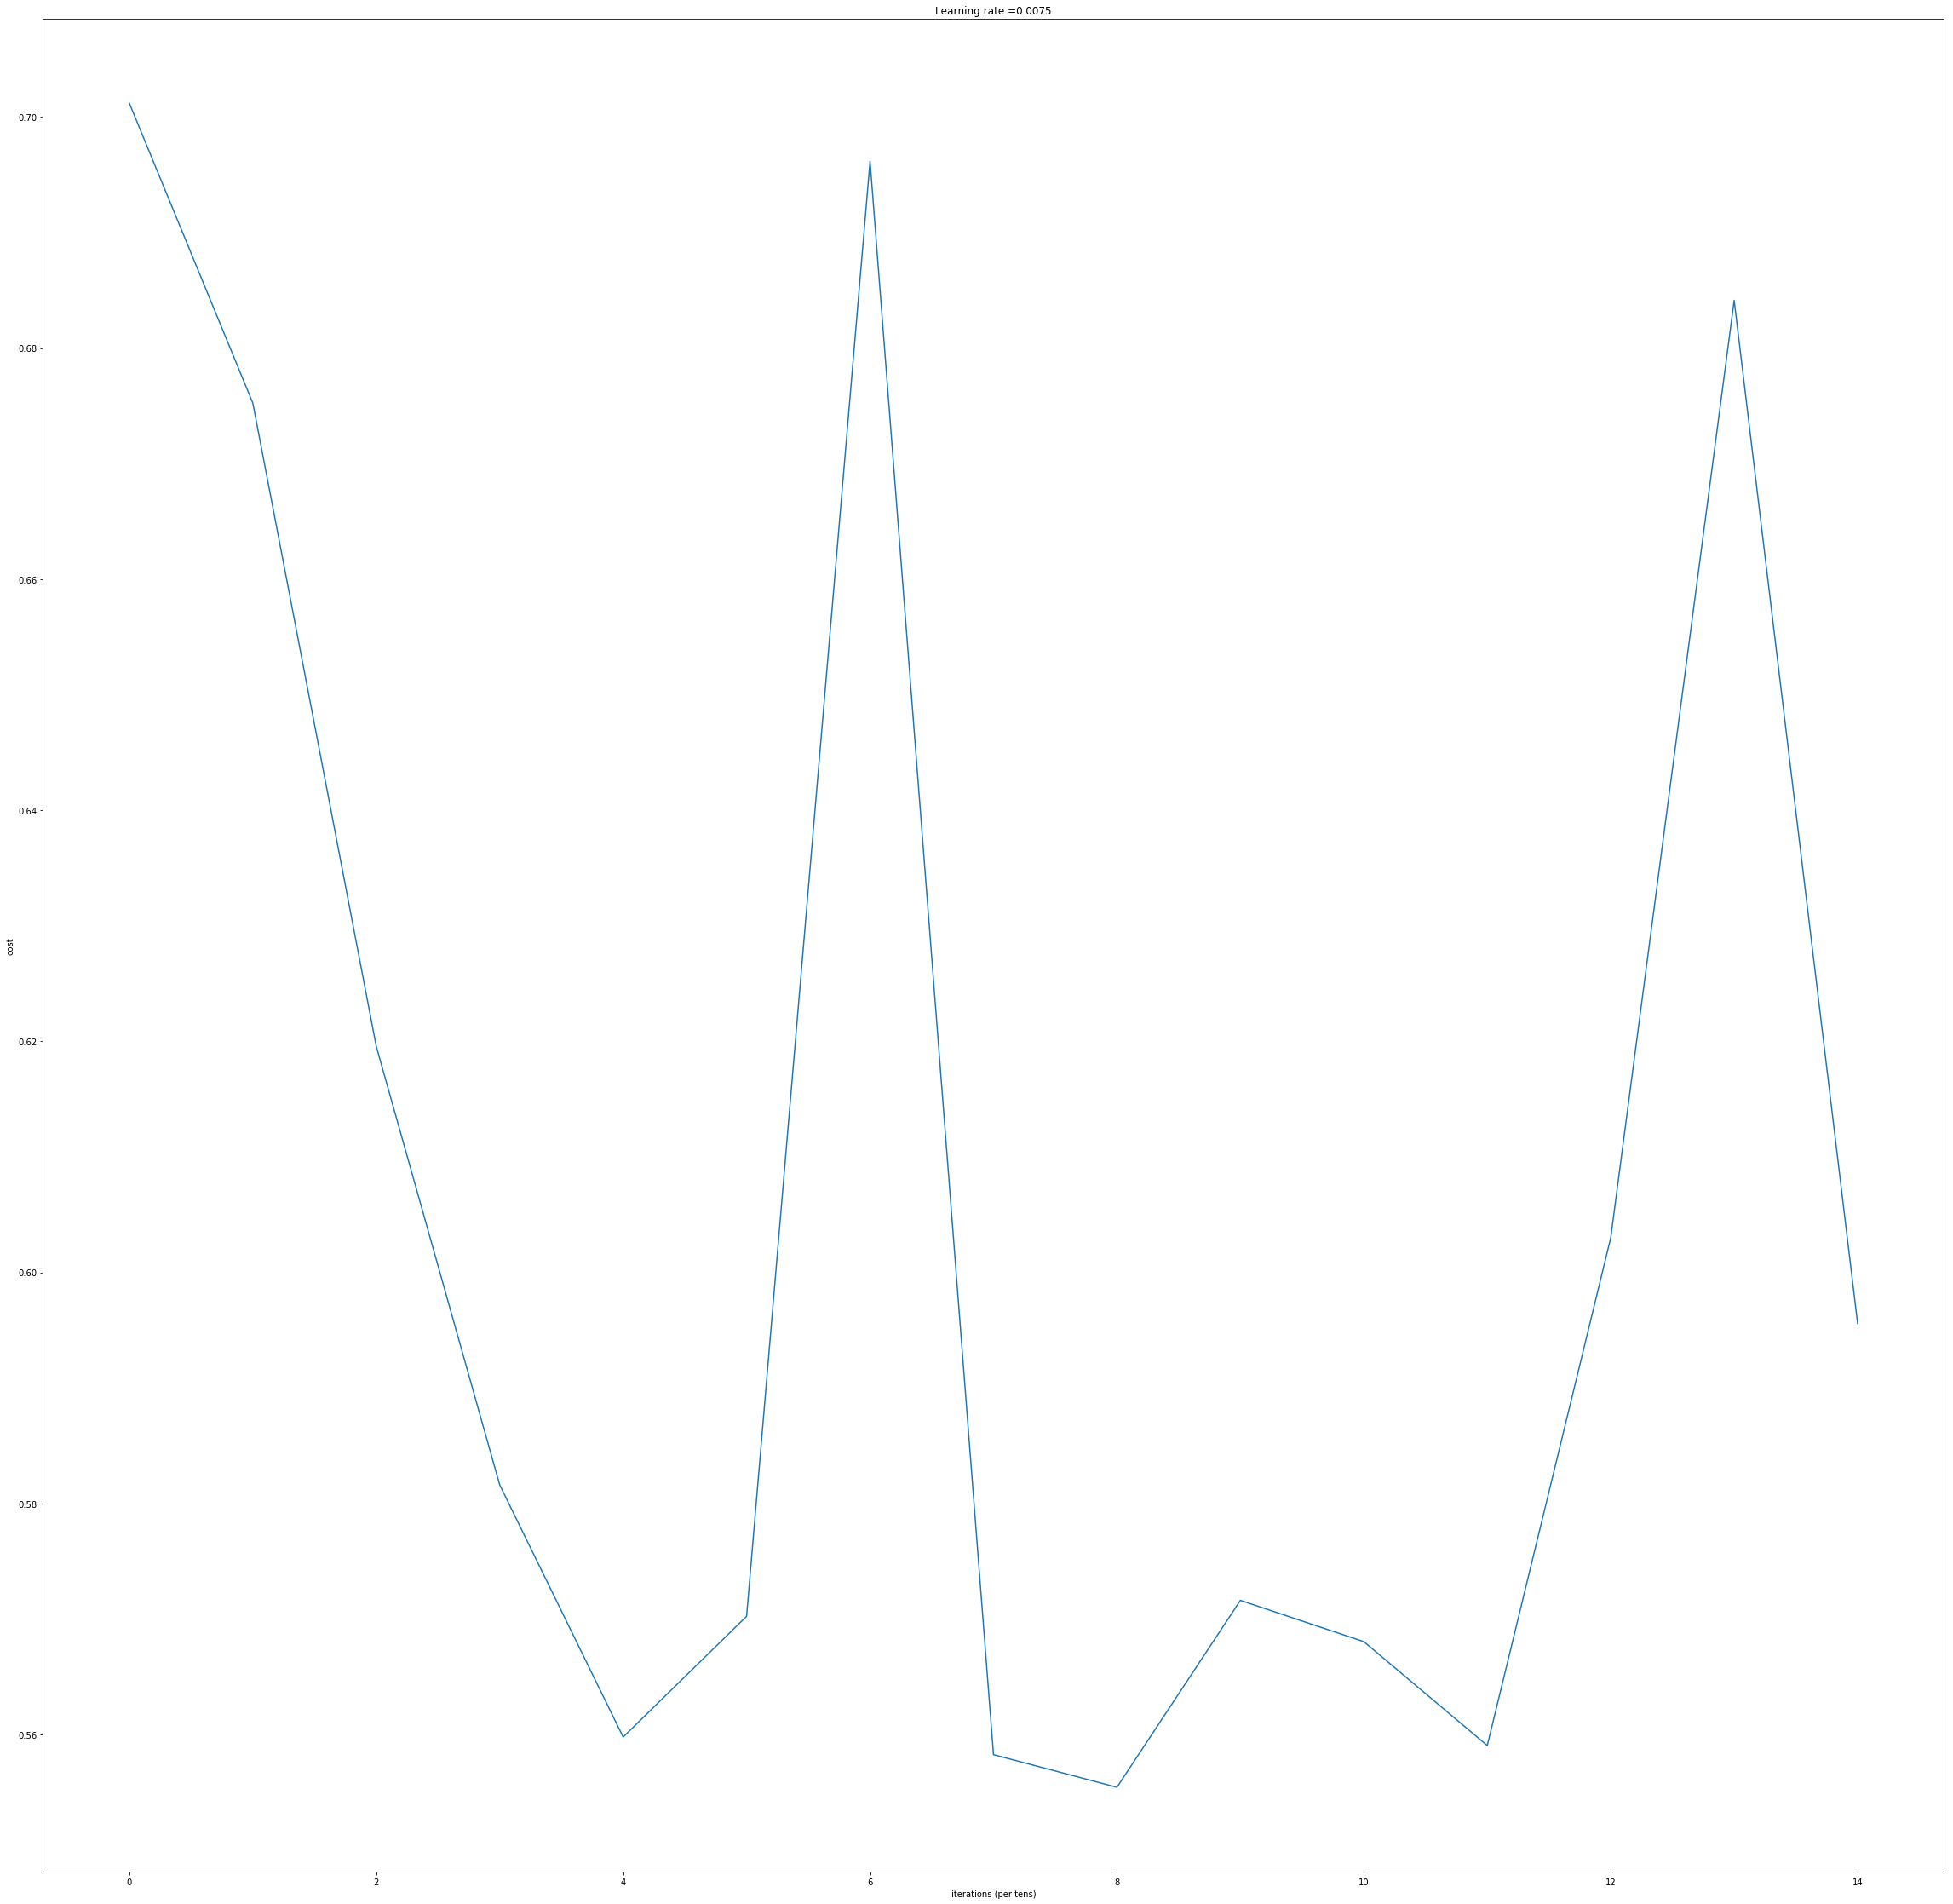

In [46]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.0075, num_iterations = 1500, print_cost = True)

**Salida esperada**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.092878 </td>
    </tr>
</table>

In [47]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.6724999999999999


**Salida esperada**:
<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [48]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.61


**Salida esperada**:

<table> 
    <tr>
        <td> **Test Accuracy**</td>
        <td> 0.8 </td>
    </tr>
</table>

##  4 - Conclusiones

First, let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

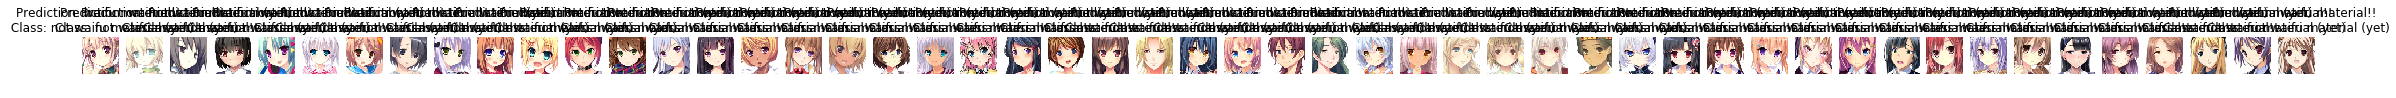

In [39]:
print_mislabeled_images(classes, test_x, test_y, pred_test)